# Double and Pseudo Double source plane cosmology forecast

In [1]:
%load_ext autoreload
%autoreload 2

# --- Standard Library ---
import copy
import os
from copy import deepcopy
from itertools import combinations
from multiprocessing import Pool, cpu_count

# --- Scientific / Numerical ---
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import norm

# --- Visualization ---
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import display, Markdown, Math
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm
import corner
from matplotlib.gridspec import GridSpec
from scipy.stats import gaussian_kde

# --- Astropy ---
from astropy import constants as const
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits
from astropy.table import Table
from astropy.units import Quantity

# --- SLSim ---
import slsim.Deflectors as deflectors
import slsim.Pipelines as pipelines
import slsim.Sources as sources
from slsim.Lenses.lens import Lens
from slsim.Lenses.lens_pop import LensPop
from slsim.LOS.los_pop import LOSPop
from slsim.Plots.lens_plots import LensingPlots

# --- Lenstronomy / HierArc ---
import emcee
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from lenstronomy.LensModel.lens_model import LensModel
from hierarc.Sampling.ParamManager.cosmo_param import CosmoParam
from hierarc.Sampling.mcmc_sampling import MCMCSampler

# --- ChainConsumer ---
from chainconsumer import Chain, ChainConfig, ChainConsumer, PlotConfig, Truth
from chainconsumer.plotting import plot_contour

# --- Local Utilities ---
from utils import normalize_data, get_pairs_table_PDSPL, kdtree_matching_n_dim, draw_lens_from_given_zs

# --- Matplotlib Style ---
plt.style.use("paper_style.mplstyle")

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-068 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-071
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf
/Users/paras/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/paras/Projects/repos/self/slsim/slsim/Plots/lens_plots.py:5: UserWarning: If you want to simulate images with Roman filters, please install the galsim module.
Note that this module is not supported on Windows
  from slsim.ImageSimulation.roman_image_simulation import simulate_roman_image


In [2]:
POSTERIOR_DIR = "../data/posteriors/"
FIGURES_DIR = "../figures/forecasts/"

## Prepare LSST like samples for Single Visit, Y10, and 4MOST 

In [3]:
########################################################
### Load the GGL data table and apply selection cuts!
########################################################

sky_area = "20000.0"
GGL_data_table = Table.read(f"../data/FULL_LSST/GGL_{sky_area}_SQDEG_NON_SIS.fits", format='fits')
# GGL_data_table = Table.read(f"../data/FULL_LSST/GGL_{sky_area}_SQDEG_NON_SIS_UNIQUE_DEFLECTORS.fits", format='fits')

contrast_mask = np.zeros(len(GGL_data_table), dtype=bool)
# ps_magnification_mask = np.zeros(len(GGL_data_table), dtype=bool)
for i in range(len(GGL_data_table)):
    
    # contrast mask
    all_vals = GGL_data_table['contrast_ratio_i'][i]
    all_vals = all_vals[~np.isnan(all_vals)]
    # get linear scale values
    all_vals = 10**(-0.4 * all_vals)
    contrast_mask[i] = np.all(all_vals > 2) # all images should have contrast ratio > 2

    # point source magnification mask
    # ps_magnifications = GGL_data_table['ps_magnification'][i]
    # ps_magnifications = ps_magnifications[~np.isnan(ps_magnifications)]
    # high_mag = np.any(np.abs(ps_magnifications) > 3)
    # ps_magnification_mask[i] = high_mag

# add a column for r_band lensed source magnitude
GGL_data_table['mag_S_r_lensed'] = GGL_data_table['mag_S_r'] - 2.5 * np.log10(np.abs(GGL_data_table['es_magnification']))
GGL_data_table['mag_S_i_lensed'] = GGL_data_table['mag_S_i'] - 2.5 * np.log10(np.abs(GGL_data_table['es_magnification']))

# add g-r and r-i colors for deflector
GGL_data_table['color_D_gr'] = GGL_data_table['mag_D_g'] - GGL_data_table['mag_D_r']
GGL_data_table['color_D_ri'] = GGL_data_table['mag_D_r'] - GGL_data_table['mag_D_i']

# add log columns
GGL_data_table['log_R_e_kpc'] = np.log10(GGL_data_table['R_e_kpc'])
GGL_data_table['log_Sigma_half_Msun/pc2'] = np.log10(GGL_data_table['Sigma_half_Msun/pc2'])
GGL_data_table['log_sigma_v_D'] = np.log10(GGL_data_table['sigma_v_D'])

GGL_data_table = GGL_data_table[ 
                                # (GGL_data_table['mag_D_i'] >= 19) & # optional, but reasonable for realistic deflectors
                                (GGL_data_table['mag_S_i_lensed'] < 28)
                                & (GGL_data_table['mag_D_i'] < 28)
                                & (contrast_mask)
                                & (np.abs(GGL_data_table['es_magnification']) > 3)
                                # & (ps_magnification_mask)
                                ]

# remove duplicates
# GGL_data_table = GGL_data_table[np.unique(GGL_data_table['z_D'], return_index=True)[1]]

GGL_data_table

lens_id,z_D,z_S,theta_E,sigma_v_D,stellar_mass_D,mag_S_i,mag_S_r,mag_S_g,mag_S_z,mag_S_y,mag_D_i,mag_D_r,mag_D_g,mag_D_z,mag_D_y,size_D,e1_mass_D,e2_mass_D,e_mass_D,gamma_pl,R_e_kpc,Sigma_half_Msun/pc2,surf_bri_mag/arcsec2,num_images,contrast_ratio_i,contrast_ratio_r,contrast_ratio_g,contrast_ratio_z,contrast_ratio_y,ps_magnification,es_magnification,R_e_arcsec,mag_S_r_lensed,mag_S_i_lensed,color_D_gr,color_D_ri,log_R_e_kpc,log_Sigma_half_Msun/pc2,log_sigma_v_D
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,object,object,object,object,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64
0,0.329124822435322,1.0051241911718725,0.7363886012965237,204.95721128465118,275998973063.0321,25.94413434762533,26.446866065929875,26.901160154345234,25.41608564735612,25.198691277756744,18.473213998207086,18.998168679136697,20.326978780985307,18.18745500089087,18.017140693630708,0.6211472127946348,-0.09393377584227298,-0.16505803588587262,0.18991500586970056,2.321328016088915,2.9465977208867837,8535.89328257733,21.757217663234215,2,[-2.4220773 -1.28337688 nan nan],[-2.44430027 -1.30559985 nan nan],[-3.31881628 -2.18011586 nan nan],[-2.66436701 -1.52566659 nan nan],[-2.71144707 -1.57274665 nan nan],[ 2.92207111 -1.07341961 nan nan],4.173255766980806,0.6211472127946348,24.895678560426354,24.39294684212181,1.3288101018486103,0.5249546809296106,0.46932084860040457,3.9312489768150187,2.3116632032869937
2,1.5396965757178396,4.066533840144556,0.5933648988866821,231.10867185666163,389289198801.96466,24.900236495349702,24.922141654357382,25.763978022146283,24.725872734929496,24.683270988046196,24.41195843790899,25.130329765942452,25.30026978999013,23.730460832500615,23.255917419169965,0.28476868766254126,-0.06688414245898035,-0.07483269760643144,0.10036643434699066,1.9636670626037047,2.4116322493391453,9733.655223494123,25.046405207401236,2,[-6.91412895 -4.66572158 nan nan],[-7.61059512 -5.36218775 nan nan],[-6.93869877 -4.69029141 nan nan],[-6.4069951 -4.15858774 nan nan],[-5.97505344 -3.72664607 nan nan],[ 2.92800817 -1.97668935 nan nan],5.071634728656454,0.28476868766254126,23.159271736692816,23.137366577685135,0.16994002404767627,0.7183713280334629,0.3823110827967278,3.988275959003662,2.363816241752744
3,0.8225987025699782,2.366507264296516,0.9668295355099917,259.62963891734057,542551704224.9811,25.42476006841597,25.666408789606926,26.01763736223713,25.216602806393354,24.925045335560704,21.013526126833924,22.171608359503182,23.605021431468003,20.288169411022842,20.01538502099843,0.4462983000792573,-0.00861094230919072,0.1274912291350796,0.1277816960046531,1.835514582302274,3.382329505014604,7244.8980947256905,24.32302122251722,2,[-4.65708854 -2.21916653 nan nan],[-5.57352205 -3.13560004 nan nan],[-6.65570655 -4.21778454 nan nan],[-4.13988909 -1.70196708 nan nan],[-4.15866217 -1.72074016 nan nan],[ 4.24962347 -1.70365791 nan nan],6.3961411913084785,0.4462983000792573,23.651613684625712,23.409964963434756,1.4334130719648215,1.1580822326692584,0.5292159140952236,3.8600322811516294,2.4143542693436544
5,1.5171235169191208,2.5465475424063917,0.6723012778010724,303.7585859107459,810824890889.5197,25.019755560697423,25.16387716380412,25.26612378578275,25.065684701825038,24.946643206818198,23.480512006952782,24.623619500693746,25.16421667728064,22.744252502352037,22.077746297186646,0.9863277959653846,-0.11291634955715528,-0.1482659157157352,0.1863676038380576,1.9241066977496035,8.34989790387258,4966.993360524251,27.601580718709098,2,[-5.37082001 -3.52830932 nan nan],[-6.3698059 -4.52729521 nan nan],[-6.80815645 -4.96564577 nan nan],[-4.58863136 -2.74612068 nan nan],[-4.04116665 -2.19865597 nan nan],[ 4.03371445 -0.99858105 nan nan],6.800722117078591,0.9863277959653844,23.082489589828263,22.938367986721566,0.5405971765868927,1.1431074937409633,0.9216811652972743,3.69609357946580

In [4]:
########################################################
### Apply LSST magnitude depth cuts and produce pdspl_samples
########################################################

########################################################
# single exposure
# point source depths: g < 26.0, r < 25.7, i < 25.0, z < 24.3, y < 23.1
# extended source depths are 1 mag shallower: g < 25.0, r < 24.7, i < 24.0, z < 23.3, y < 22.1

# 10 year coadd
# point source depths: g < 27.4, r < 27.5, i < 26.8, z < 26.1, y < 24.9
# extended source depths are 1 mag shallower: g < 26.4, r < 26.5, i < 25.8, z < 25.1, y < 23.9

# 4MOST spec-z : r < 23.5 and z_S < 1.5

# 4MOST sigma_v_D : 50% of the spec-z sample will have sigma_v_D measurements, Collett et al 2023 [https://www.eso.org/sci/publications/messenger/archive/no.190-mar23/messenger-no190-49-52.pdf]
########################################################

# Define all LSST sample configurations in one structured dictionary
pdspl_samples = {
    # "slsim_20K_deg_sq.": {
    #     "mask": np.ones(len(GGL_data_table), dtype=bool),
    #     "title": f"SLSim Full Sample ({sky_area} deg$^2$)",
    #     "label": "SLSim Full Sample",
    #     "color": "tab:blue",
    #     "desc": "SLSim full sample; extended-source $i < 28.0$",
    #     "selc_func_latex": "$m_{i} < 28.0$"
    # },
    # "lsst_single_visit": {
    #     "mask": (
    #         (GGL_data_table["mag_D_i"] < 24.0)
    #         & (GGL_data_table["mag_S_i_lensed"] < 24.0)
    #         & (GGL_data_table["R_e_arcsec"] > 0.7) # added cut on R_e_arcsec > 0.7 arcsec at LSST seeing
    #     ),
    #     "title": f"LSST Single Visit Depth ({sky_area} deg$^2$)",
    #     "label": "LSST SINGLE ($i < 24.0$)",
    #     "name": "LSST SINGLE",
    #     "color": "tab:orange",
    #     "desc": "Single exposure; extended-source $i < 24.0$",
    #     "selc_func_latex": "$m_{i} < 24.0, R_e > 0.7''$"
    # },

    "lsst_y10": {
        "mask": (
            (GGL_data_table["mag_D_i"] < 25.8)
            & (GGL_data_table["mag_S_i_lensed"] < 25.8)
            & (GGL_data_table["R_e_arcsec"] > 0.7) # added cut on R_e_arcsec > 0.7 arcsec at LSST seeing
        ),
        "title": f"LSST 10-year Coadd Depth ({sky_area} deg$^2$)",
        "label": "LSST Y10 ($i < 25.8$)",
        "name": "LSST Y10",
        "color": "tab:green",
        "desc": "10-year coadd; extended-source $i < 25.8$",
        "selc_func_latex": "$m_{i} < 25.8, R_e > 0.7''$"
    },

    "lsst_4most_spec-z": {
        "mask": (
            (GGL_data_table["mag_S_r_lensed"] < 24.0) &
            (GGL_data_table["z_S"] < 1.5) &
            (GGL_data_table["R_e_arcsec"] > 0.7) # added cut on R_e_arcsec > 0.7 arcsec at LSST seeing
        ),
        "title": f"LSST + 4MOST spec-z Sample ({sky_area} deg$^2$)",
        "label": "LSST Y10 + 4MOST ($r < 24, z_S < 1.5$)",
        "name": "LSST Y10 + 4MOST (spec-z)",
        "color": "tab:red",
        "desc": "Spectroscopic 4MOST limit; $r < 24, z_S < 1.5$",
        "selc_func_latex": "$m_{r} < 24.0, z_S < 1.5, R_e > 0.7''$"
    },

    "lsst_4most_spec-z_sigma_v": {
        "mask": None,  # to be filled later, # half of the brightest 4MOST spec-z sample will have sigma_v measurements
        "title": f"LSST + 4MOST spec-z + "+"$\\sigma_{v, D}$"+f" Sample ({sky_area} deg$^2$)",
        "label": "LSST Y10 + 4MOST ($r < 24, z_S < 1.5$)",
        "name": "LSST Y10 + 4MOST (spec-z + $\\sigma_{v, D}$)",
        "color": "tab:purple",
        "desc": "Spectroscopic 4MOST limit; $r < 24, z_S < 1.5$",
        "selc_func_latex": "$m_{r} < 24.0, z_S < 1.5, R_e > 0.7''$"
    },
}

# Build filtered tables
for key, s in pdspl_samples.items():
    if key == 'lsst_4most_spec-z_sigma_v':
        org_mask = pdspl_samples['lsst_4most_spec-z']["mask"]
        # 50% of the brightest 4MOST spec-z sample will have sigma_v_D measurements
        brightest_indices = np.argsort(GGL_data_table['mag_D_i'])[:org_mask.sum() // 2]
        new_mask = np.zeros(len(GGL_data_table), dtype=bool)
        new_mask[brightest_indices] = True
        s["mask"] = new_mask

    s["table"] = GGL_data_table[s["mask"]]
    s["count"] = len(s["table"])

# Summary
print('-'*80)
print(f"Sky area: {sky_area} deg^2")
print('-'*80)
print(f"SLSim (i < 28, contrast_ratio > 2, mu_tot > 3, theta_E > 1\")  # lenses: {len(GGL_data_table)}")

for key, s in pdspl_samples.items():
    print(f"{s['name']:<62}# lenses: {s['count']}")

print('-'*80)

--------------------------------------------------------------------------------
Sky area: 20000.0 deg^2
--------------------------------------------------------------------------------
SLSim (i < 28, contrast_ratio > 2, mu_tot > 3, theta_E > 1")  # lenses: 322403
LSST Y10                                                      # lenses: 153725
LSST Y10 + 4MOST (spec-z)                                     # lenses: 5113
LSST Y10 + 4MOST (spec-z + $\sigma_{v, D}$)                   # lenses: 2556
--------------------------------------------------------------------------------


In [5]:
# --- Cosmology used in SLSim and to use for forecasting ---
cosmology = "w0waCDM"  # Flat wCDM cosmology
# other options are: "FLCDM FwCDM", "w0waCDM", "oLCDM"
om_true = 0.3
w0_true = -1
wa_true = 0
h0_true = 70
kwargs_cosmo_true = {"h0": h0_true, "om": om_true, "w0": w0_true, "wa": wa_true}  # cosmological model of the forecast

cosmo_param = CosmoParam(cosmology=cosmology)
cosmo_true = cosmo_param.cosmo(kwargs_cosmo_true)

In [6]:
########################################################
### Pairing Properties and Titles
########################################################

# --- Deflector properties used for pairing ---
keys_to_pair_deflectors = [
    'z_D',
    'R_e_arcsec',
    'mag_D_i',
    'color_D_gr',
    'color_D_ri',
]

keys_to_pair_deflectors_latex = {
    'z_D': r'$z_{\mathrm{lens}}$',
    'R_e_kpc': r'$R_e$ [kpc]',
    'R_e_arcsec': r'$R_e$ [arcsec]',
    'mag_D_i': r'$m_i$',
    'color_D_gr': r'$m_g - m_r$',
    'color_D_ri': r'$m_r - m_i$',
    'sigma_v_D': r'$\sigma_{v, D}$ [km/s]',
} 

# assign pairing keys for each sample
for key, s in pdspl_samples.items():
    if key == 'lsst_4most_spec-z_sigma_v':
        pairing_keys = ['z_D', 'R_e_arcsec', 'sigma_v_D']
    else:
        pairing_keys = keys_to_pair_deflectors

    s['pairing_keys'] = pairing_keys
    s['pairing_title'] = "Paired w/ kD-Tree in " + ", ".join(
        [keys_to_pair_deflectors_latex[k] for k in pairing_keys]
    )
    s['pairing_keys_latex'] = ', '.join(
        [keys_to_pair_deflectors_latex[k] for k in pairing_keys]
    )

########################################################
## Adding errors on z_D and sigma_v_D
##########################################################

for sample_key in pdspl_samples.keys():

    # z_D errors
    if sample_key in ['lsst_single_visit', 'lsst_y10']:    
        z_D_error = 0.03 * (1 + pdspl_samples[sample_key]['table']['z_D'])  # photometric redshift error from LSST Science Book
        sample_z_Ds_with_errors = pdspl_samples[sample_key]['table']['z_D'] + np.random.normal(loc=0, scale=z_D_error)
    elif sample_key in ['lsst_4most_spec-z', 'lsst_4most_spec-z_sigma_v']:
        z_D_error = 1e-4 # spectroscopic redshift error
        sample_z_Ds_with_errors = pdspl_samples[sample_key]['table']['z_D'] + np.random.normal(loc=0, scale=z_D_error)  
    else:
        sample_z_Ds_with_errors = pdspl_samples[sample_key]['table']['z_D']
    
    # sigma_v_D errors
    if sample_key == 'lsst_4most_spec-z_sigma_v':
        sigma_v_error = 10.0  # fixed 10 km/s error on sigma_v_D [https://ui.adsabs.harvard.edu/abs/2024MNRAS.527.5311L/abstract]
        sample_sigma_v_Ds_with_errors = pdspl_samples[sample_key]['table']['sigma_v_D'] + np.random.normal(loc=0, scale=sigma_v_error)
    else:
        sample_sigma_v_Ds_with_errors = pdspl_samples[sample_key]['table']['sigma_v_D']

    # R_e errors => 5-10% error on R_e
    R_e_error = 0.05 * (pdspl_samples[sample_key]['table']['R_e_arcsec'])
    sample_R_e_arcsec_with_errors = pdspl_samples[sample_key]['table']['R_e_arcsec'] + np.random.normal(loc=0, scale=R_e_error)

    # add these errors to a new table
    pdspl_samples[sample_key]['table_with_errors'] = pdspl_samples[sample_key]['table'].copy()
    pdspl_samples[sample_key]['table_with_errors']['z_D'] = sample_z_Ds_with_errors
    pdspl_samples[sample_key]['table_with_errors']['sigma_v_D'] = sample_sigma_v_Ds_with_errors
    pdspl_samples[sample_key]['table_with_errors']['R_e_arcsec'] = sample_R_e_arcsec_with_errors
########################################################

########################################################
## define dissimilarity estimator parameters for each sample
##########################################################
# --- Define which parameters to include in the dissimilarity estimator ---
keys_to_use_for_dissimilarity = [
    "rel_diff_R_e_arcsec",
    "rel_diff_z_D",
    "rel_diff_mag_D_i",
    "rel_diff_color_D_gr",
    "rel_diff_color_D_ri"
]

# --- (optional) Define pretty LaTeX labels for each key ---
key_latex_map = {
    "rel_diff_R_e_arcsec": r"\frac{\Delta R_e}{R_e}",
    "rel_diff_z_D": r"\frac{\Delta z_D}{z_D}",
    "rel_diff_mag_D_i": r"\frac{\Delta m_i}{m_i}",
    "rel_diff_color_D_gr": r"\frac{\Delta c_{gr}}{c_{gr}}",
    "rel_diff_color_D_ri": r"\frac{\Delta c_{ri}}{c_{ri}}"
}

# assign dissimilarity keys for each sample
for key, s in pdspl_samples.items():
    if key == 'lsst_4most_spec-z_sigma_v':
        dissimilarity_keys = [
            "rel_diff_z_D",
            "rel_diff_R_e_arcsec",
            "rel_diff_sigma_v_D"
        ]
    else:
        dissimilarity_keys = keys_to_use_for_dissimilarity

    s['dissimilarity_keys'] = dissimilarity_keys
############################################################


########################################################
## define pairs selection function to select near-identical deflectors within 1 sigma
##########################################################
def select_near_identical_deflectors(sample, pairs_table_with_errors, sigma = 0.02):

    diffs = np.array([pairs_table_with_errors[k] for k in sample['dissimilarity_keys']])
    estimator = np.sqrt(np.mean(diffs**2, axis=0))

    idxs = np.where(estimator < sigma)[0]

    return pairs_table_with_errors[idxs], idxs
########################################################

In [7]:
########################################################
###  Get pairs table for each LSST sample
########################################################

for sample_key, s in pdspl_samples.items():
    table = s["table"]

    if len(table) < 2:
        print(f"⚠️ Skipping {sample_key}: too few lenses ({len(table)})")
        continue

    # print(f"\nBuilding full pairs table for {s['name']} ...")

    pairing_keys = s['pairing_keys']
    pairing_title = s['pairing_title']

    # Normalized feature space, use table with errors for pairing
    points = np.stack(
        [normalize_data(s['table_with_errors'][pk], type='zscore') for pk in pairing_keys],
        axis=1
    )

    # Pair with KD-tree
    indices, _ = kdtree_matching_n_dim(points=points, n_neighbors=2, unique_pairs=True)

    # Build pairs table from kD-tree indices
    pairs_table = get_pairs_table_PDSPL(table, pair_indices=indices, cosmo=cosmo_true)
    pairs_table_with_errors = get_pairs_table_PDSPL(s['table_with_errors'], pair_indices=indices, cosmo=cosmo_true)

    # Compute summary stats
    num_lenses = len(table)
    num_pairs = len(pairs_table)
    beta_ratio = pairs_table["beta_E_pseudo"] / pairs_table["beta_E_DSPL"]
    scatter_in_beta_E = np.std(1 - beta_ratio)
    mean_beta_ratio = np.mean(beta_ratio)
    median_beta_ratio = np.median(beta_ratio)

    # Store results inside the sample dict
    s["pairs_analysis"] = {
        "pairs_table": pairs_table,
        "pairs_table_with_errors": pairs_table_with_errors,
        "num_lenses": num_lenses,
        "num_pairs": num_pairs,
        "scatter_in_beta_E": scatter_in_beta_E,
        "mean_beta_ratio": mean_beta_ratio,
        "median_beta_ratio": median_beta_ratio,
        "pairing_keys": pairing_keys,
        "pairing_title": pairing_title,
        "pairing_points": points,
    }

    print(f"✅ {s['name']}: {num_pairs} pairs, scatter = {scatter_in_beta_E:.4f}")

########################################################
###  Find dissimilarity estimator for each LSST sample and attach to pairs table
########################################################
for sample_key, s in pdspl_samples.items():
    pairs_table_with_errors = s["pairs_analysis"]["pairs_table_with_errors"]
    diffs = np.array([pairs_table_with_errors[k] for k in s['dissimilarity_keys']])
    dissimilarity_estimator = np.sqrt(np.mean(diffs**2, axis=0))
    s["pairs_analysis"]["pairs_table_with_errors"]['dissimilarity'] = dissimilarity_estimator
########################################################

Processing pairs: 100%|██████████| 112135/112135 [00:19<00:00, 5675.62it/s]


✅ LSST Y10: 112135 pairs, scatter = 0.1869


Processing pairs: 100%|██████████| 3705/3705 [00:00<00:00, 5713.45it/s]


✅ LSST Y10 + 4MOST (spec-z): 3705 pairs, scatter = 0.1151


Processing pairs: 100%|██████████| 1777/1777 [00:00<00:00, 5724.30it/s]

✅ LSST Y10 + 4MOST (spec-z + $\sigma_{v, D}$): 1777 pairs, scatter = 0.0444


LSST Y10: scatter vs dissimilarity fit: slope = 0.388, intercept = -0.132
LSST Y10 + 4MOST (spec-z): scatter vs dissimilarity fit: slope = 0.385, intercept = -0.350
LSST Y10 + 4MOST (spec-z + $\sigma_{v, D}$): scatter vs dissimilarity fit: slope = 0.118, intercept = -1.169


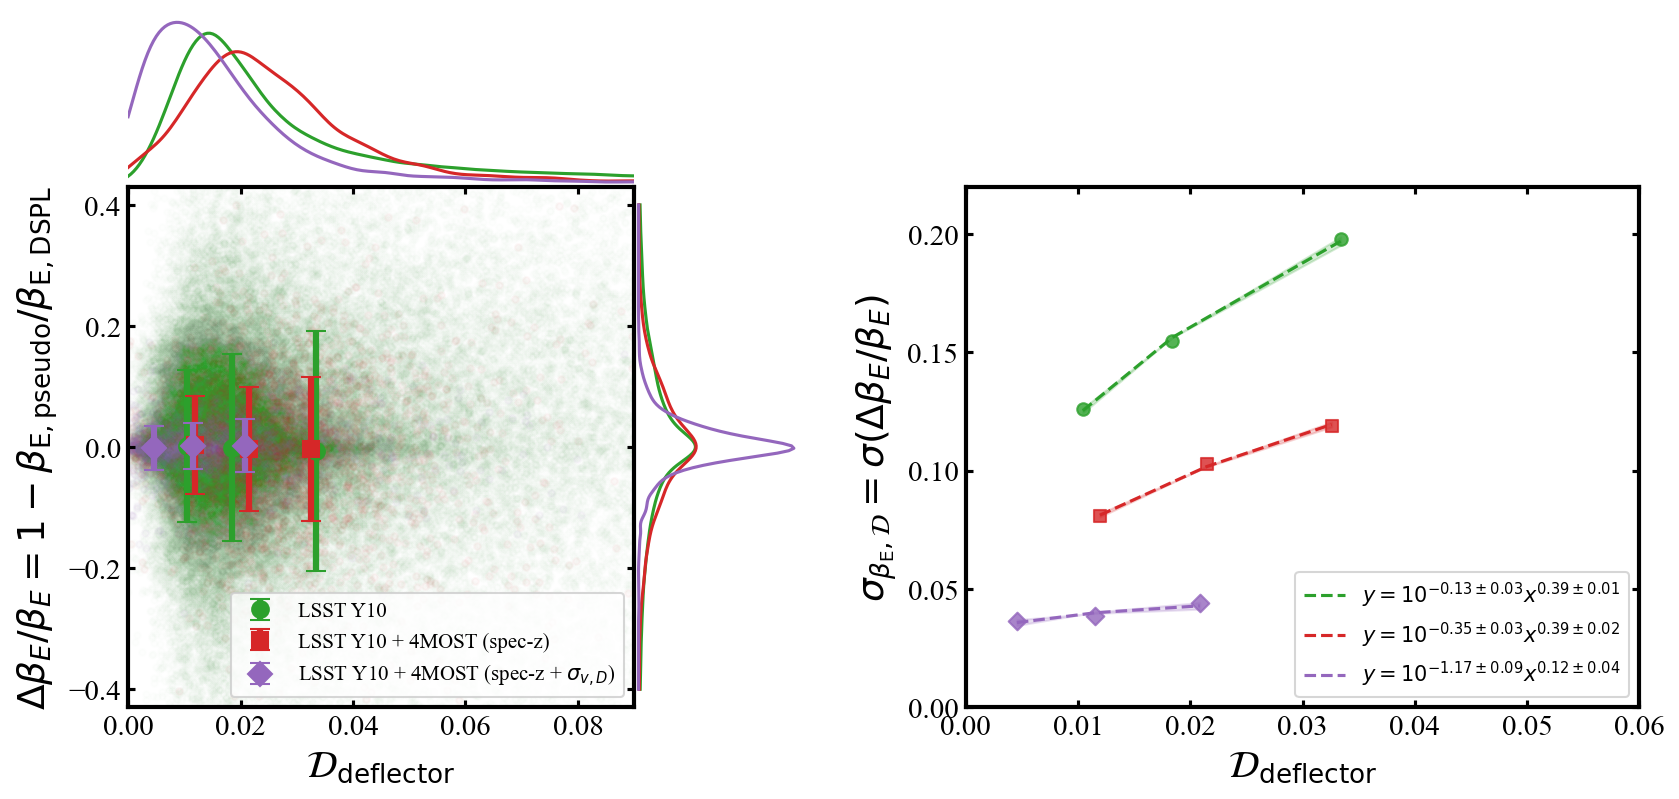

In [8]:
########################################
### scatter_beta_E as a function of dissimilarity
########################################

alpha_vals = {
    "lsst_y10": 0.007,
    "lsst_4most_spec-z": 0.03,
    "lsst_4most_spec-z_sigma_v": 0.04,
}

markers = {
    "lsst_y10": "o",
    "lsst_4most_spec-z": "s",
    "lsst_4most_spec-z_sigma_v": "D",
}

# --- Set up figure layout
fig = plt.figure(figsize=(13, 6))
gs = GridSpec(4, 9, figure=fig, wspace=-0.02, hspace=-0.02,
              )

ax_scatter = fig.add_subplot(gs[1:, 0:3])
ax_histx   = fig.add_subplot(gs[0, 0:3], sharex=ax_scatter)
ax_histy   = fig.add_subplot(gs[1:, 3], sharey=ax_scatter)
ax_fit = fig.add_subplot(gs[1:, 5:9])


# --- Loop through samples
for sample_key, s in pdspl_samples.items():
    tbl_err = s["pairs_analysis"]["pairs_table_with_errors"]
    tbl = s["pairs_analysis"]["pairs_table"]

    dissimilarities = tbl_err['dissimilarity']
    delta_beta_E = 1 - tbl['beta_E_pseudo'] / tbl['beta_E_DSPL']

    # limit to dissimilarity < 0.1 for better visualization
    mask = (tbl_err['dissimilarity'] < 0.1) & (np.isfinite(delta_beta_E))
    tbl_err = tbl_err[mask]
    tbl = tbl[mask]

    dissimilarities = tbl_err['dissimilarity']
    delta_beta_E = 1 - tbl['beta_E_pseudo'] / tbl['beta_E_DSPL']

    # Scatter
    ax_scatter.scatter(
        dissimilarities,
        delta_beta_E,
        color=s['color'],
        alpha=alpha_vals[sample_key],
        s=10,
    )

    # Histograms
    # ax_histx.hist(dissimilarities, bins=40, color=s['color'], histtype='step',
    #               density=True)
    # ax_histy.hist(delta_beta_E, bins=40, color=s['color'], orientation='horizontal', histtype='step',
    #               density=True)
    
    # --- KDE smoothed histograms
    kde_x = gaussian_kde(dissimilarities)
    kde_y = gaussian_kde(delta_beta_E)
    x_grid = np.linspace(0, 0.1, 200)
    y_grid = np.linspace(-0.4, 0.4, 200)
    ax_histx.plot(x_grid, kde_x(x_grid), color=s['color'], lw=1.5)
    ax_histy.plot(kde_y(y_grid), y_grid, color=s['color'], lw=1.5)

    
    # bin the dissimilarities, using percentiles, use np.digitize to bin
    percentiles = np.percentile(dissimilarities, np.arange(0, 101, 30))
    digitized = np.digitize(dissimilarities, percentiles)

    binned_dissimilarities = []
    binned_scatter_beta_E = []
    binned_means_beta_E = []

    for i in range(1, len(percentiles)):
        bin_mask = digitized == i
        if np.sum(bin_mask) > 0:
            binned_dissimilarities.append(np.median(dissimilarities[bin_mask]))
            scatter_in_beta_E = np.nanstd(delta_beta_E[bin_mask])
            binned_scatter_beta_E.append(scatter_in_beta_E)
            binned_means_beta_E.append(np.nanmean(delta_beta_E[bin_mask]))

    # on the original scatter plot, plot the binned means +- scatter
    ax_scatter.errorbar(
        binned_dissimilarities,
        binned_means_beta_E,
        yerr=binned_scatter_beta_E,
        fmt=markers[sample_key],
        color=s['color'],
        markersize=8,
        # markeredgecolor='k',
        label=s['name'],
        capsize=5,
        elinewidth=3,
    )

    # plot the binned scatter vs binned dissimilarity
    ax_fit.scatter(
        binned_dissimilarities,
        binned_scatter_beta_E,
        marker=markers[sample_key],
        color=s['color'],
        # label=s['name'],
        alpha=0.8,
    )
    
    # fit a line in log-log space, use covariance matrix to get uncertainties
    coeffs, cov = np.polyfit(np.log10(np.array(binned_dissimilarities)), 
                            np.log10(np.array(binned_scatter_beta_E)), 1, cov=True)
    
    # fit equation latex
    fit_eq_latex = r"$y = 10^{%.2f \pm %.2f} x^{%.2f \pm %.2f}$" % (
        coeffs[1], np.sqrt(cov[1, 1]),
        coeffs[0], np.sqrt(cov[0, 0])
    )

    # fitted line and 1-sigma uncertainty region
    ax_fit.plot(
        np.array(binned_dissimilarities),
        10**(np.polyval(coeffs, np.log10(np.array(binned_dissimilarities)))),
        linestyle='--',
        color=s['color'],
        label = fit_eq_latex
    )
    ax_fit.fill_between(
        np.array(binned_dissimilarities),
        10**(np.polyval(coeffs - np.sqrt(np.diag(cov)), np.log10(np.array(binned_dissimilarities)))),
        10**(np.polyval(coeffs + np.sqrt(np.diag(cov)), np.log10(np.array(binned_dissimilarities)))),
        color=s['color'],
        alpha=0.2,
    )

    # attach the fitted coeffs to the sample dict
    s['pairs_analysis']['scatter_vs_dissimilarity_fit_coeffs'] = coeffs

    # print the fit results
    print(f"{s['name']}: scatter vs dissimilarity fit: slope = {coeffs[0]:.3f}, intercept = {coeffs[1]:.3f}")
    
    

# --- Labels, limits, etc.
ax_scatter.set_xlabel(r"$\mathcal{D}_{\rm deflector}$")
ax_scatter.set_ylabel(r"$\Delta \beta_{E} / \beta_{E} = 1 - \beta_{\rm E, pseudo}/\beta_{\rm E, DSPL}$")
ax_scatter.set_xlim(0, 0.09)
ax_scatter.set_ylim(-0.43, 0.43)
ax_scatter.legend(frameon=True)

# --- Hide axis for the marginal histograms
ax_histx.axis('off')
ax_histy.axis('off')


# --- Fit panel axis labels
ax_fit.set_xlabel(r"$\mathcal{D}_{\rm deflector}$")
ax_fit.set_ylabel(r"$\sigma_{\beta_{\rm E},\rm \mathcal{D}} = \sigma(\Delta \beta_{E} / \beta_{E})$")
ax_fit.set_xlim(0, 0.06)
ax_fit.set_ylim(0, 0.22)
ax_fit.legend(frameon=True)


# --- Save figure
fig.savefig(f"../figures/beta_E_vs_D.png", dpi=300, bbox_inches='tight')


## Forecast settings

Here we describe the redshift distribution, precision on Einstein radii ratios of an anticipated sample


In [9]:
# define hierarchical model
kwargs_model = {
    "lambda_mst_sampling": True,
    "lambda_mst_distribution": "NONE",  # TODO: switch to GAUSSIAN
    "gamma_pl_global_sampling": True,
    "gamma_pl_global_dist": "NONE",  # TODO: switch to GAUSSIAN
    "log_scatter": False,
}

gamma_pl_mean = 2.078
gamma_pl_sigma = 0.16 # from Auger et al. 2010 for SLACS lenses

lambda_mst_mean = 1.0
lambda_mst_sigma = 0.05

In [10]:
########################################################
### Define forecast samples dictionary
########################################################

num_PDSPL_samples_forecast = 800  # number of PDSPL systems to use in forecast

forecast_samples = {
    "DSPL": {
        "num_systems": 87,  # number of DSPL systems
        "rel_scatter_in_beta_E": 0.01,  # relative scatter in beta_E from DSPL analysis
        "num_systems_forecast": 87, # only use these many systems in the forecast with appropriate downsampling factor
        "kwargs_likelihood_list": None,
        "name": "DSPL (87 lenses)",
        "color": "tab:blue",
    },
    # "lsst_single_visit": {
    #     "num_systems": ,
    #     "rel_scatter_in_beta_E": ,
    #     "num_systems_forecast": num_PDSPL_samples_forecast,
    #     "kwargs_likelihood_list": None,
    #     "name": "PDSPL (LSST SINGLE)",
    #     "color": "tab:orange",
    # },
    "lsst_y10": {
        "num_systems": len(pdspl_samples['lsst_y10']['table']),
        "num_systems_forecast": num_PDSPL_samples_forecast,
        "kwargs_likelihood_list": None,
        "name": "PDSPL (LSST Y10)",
        "color": "tab:green",
    },
    "lsst_4most_spec-z": {
        "num_systems": len(pdspl_samples['lsst_4most_spec-z']['table']),
        "num_systems_forecast": num_PDSPL_samples_forecast,
        "kwargs_likelihood_list": None,
        "name": "PDSPL (LSST Y10 + 4MOST spec-z)",
        "color": "tab:red",
    },
    "lsst_4most_spec-z_sigma_v": {
        "num_systems": len(pdspl_samples['lsst_4most_spec-z_sigma_v']['table']),
        "num_systems_forecast": num_PDSPL_samples_forecast,
        "kwargs_likelihood_list": None,
        "name": "PDSPL (LSST Y10 + 4MOST spec-z + sigma_v)",
        "color": "tab:red",
    },
}

# add down sampling factor
for key in forecast_samples.keys():
    n_total = forecast_samples[key]['num_systems']
    n_forecast = forecast_samples[key]['num_systems_forecast']
    downsample_factor = n_total / n_forecast
    forecast_samples[key]['down_sampling_factor'] = downsample_factor

########################################################
### Print forecast samples summary
########################################################
print("\nForecast Samples Summary:")
print('-'*80)
for key in forecast_samples.keys():
    s = forecast_samples[key]
    print(f"{s['name']:<42} # systems: {s['num_systems']:<10} | down-sampling factor: {s['down_sampling_factor']:.2f}")
print('-'*80)


Forecast Samples Summary:
--------------------------------------------------------------------------------
DSPL (87 lenses)                           # systems: 87         | down-sampling factor: 1.00
PDSPL (LSST Y10)                           # systems: 153725     | down-sampling factor: 192.16
PDSPL (LSST Y10 + 4MOST spec-z)            # systems: 5113       | down-sampling factor: 6.39
PDSPL (LSST Y10 + 4MOST spec-z + sigma_v)  # systems: 2556       | down-sampling factor: 3.19
--------------------------------------------------------------------------------


## Generate DSPL kwargs_likelihoods

In [11]:
########################################################
### Settings for population of DSPL
########################################################

kwargs_dspl_list = []

for i in range(forecast_samples['DSPL']['num_systems_forecast']):
    z_lens = np.random.uniform(low=0.01, high=2.5)
    z1 = 0
    while z1 < z_lens:
        z1 = np.random.uniform(low=0.1, high=5)
    z2 = 0
    while z2 < z_lens:
        z2 = np.random.uniform(low=0.1, high=5)
    if z1 > z2:
        z1, z2 = z2, z1

    kwargs_dspl_list.append(
        draw_lens_from_given_zs(z_lens, z1, z2,
                                lambda_mst_mean, lambda_mst_sigma, gamma_pl_mean, gamma_pl_sigma,
                                cosmo=cosmo_true,
                                sigma_beta=forecast_samples['DSPL']['rel_scatter_in_beta_E'],
                                with_noise=True,
                                down_sampling=forecast_samples['DSPL']['down_sampling_factor'])
                                )

forecast_samples['DSPL']['kwargs_likelihood_list'] = copy.deepcopy(kwargs_dspl_list)

/Users/paras/Projects/PDSPL/pdspl-analysis/notebooks/utils.py:39: RuntimeWarning: invalid value encountered in scalar power
  return (beta_dsp - (1 - lambda_mst) * (1 - beta_dsp)) ** (1 / (gamma_pl - 1))


## Generate PDSPL kwargs_likelihoods

In [12]:
################################################################################
### prepare samples for forecasting
################################################################################
for key in forecast_samples.keys():
    if key == 'DSPL':
        continue
    num_samples = forecast_samples[key]['num_systems_forecast']
    down_sampling_factor = forecast_samples[key]['down_sampling_factor']
    pairs_table = pdspl_samples[key]['pairs_analysis']['pairs_table']

    # based on scatter vs dissimilarity fit, get the scatter in beta_E to use for this sample
    coeffs = pdspl_samples[key]['pairs_analysis']['scatter_vs_dissimilarity_fit_coeffs']
    
    kwargs_pseudo_dspl_list = []
    for i in range(num_samples):
        # pick random pair
        rand_index = np.random.choice(len(pairs_table))
        z_lens = pairs_table["z_D"][rand_index]
        z1 = pairs_table["z_S1"][rand_index]
        z2 = pairs_table["z_S2"][rand_index]

        dissimilarity = pdspl_samples[key]['pairs_analysis']['pairs_table_with_errors']['dissimilarity'][rand_index]
        rel_scatter_in_beta_E = 10**(np.polyval(coeffs, np.log10(dissimilarity)))

        # add los and measurement noise
        sigma_beta_meas = 0.01  # relative uncertainty on the measured Einstein radius due to measurement errors
        sigma_beta_los = 0.01  # relative uncertainty on the measured Einstein radius due to line-of-sight structures
        
        rel_scatter_in_beta_E = np.sqrt(rel_scatter_in_beta_E**2 + sigma_beta_meas**2 + sigma_beta_los**2)

        kwargs_pseudo_dspl_list.append(draw_lens_from_given_zs(
            z_lens=z_lens, z1=z1, z2=z2,
            lambda_mst_mean=lambda_mst_mean, lambda_mst_sigma=lambda_mst_sigma,
            gamma_pl_mean=gamma_pl_mean, gamma_pl_sigma=gamma_pl_sigma,
            sigma_beta=rel_scatter_in_beta_E, 
            cosmo=cosmo_true,
            down_sampling=down_sampling_factor,
            with_noise=True))
        
    forecast_samples[key]['kwargs_likelihood_list'] = copy.deepcopy(kwargs_pseudo_dspl_list)

## hierArc sampling settings

In [13]:
################################################################################
### specify forecast samples to run
################################################################################

keys_to_run_forecast = [
    "DSPL",
    # "lsst_single_visit",
    "lsst_y10",
    "lsst_4most_spec-z",
    "lsst_4most_spec-z_sigma_v",
]

In [14]:
kwargs_mean_start = {"kwargs_cosmo": {"h0": 70, "om": 0.3, "w0": -1, "wa": 0},
                    "kwargs_lens": {"lambda_mst": lambda_mst_mean, "lambda_mst_sigma": lambda_mst_sigma,
                                    "gamma_pl_mean": gamma_pl_mean, "gamma_pl_sigma": gamma_pl_sigma}}

kwargs_sigma_start = {"kwargs_cosmo": {"h0": 10, "om": 0.05, "w0": 0.2, "wa": 0.1},
                     "kwargs_lens": {"lambda_mst": 0.1, "lambda_mst_sigma": 0.01,
                                     "gamma_pl_mean": 0.1, "gamma_pl_sigma": 0.01}}


kwargs_bounds = {
    "kwargs_lower_cosmo": {"h0": 0, "om": 0, "w0": -2, "wa": -3},
    "kwargs_upper_cosmo": {"h0": 200, "om": 1, "w0": 0, "wa": 3},
    "kwargs_fixed_cosmo": {"h0": kwargs_cosmo_true["h0"]},

    "kwargs_lower_lens": {"lambda_mst": 0.8, "gamma_pl_mean": 1.5,},# "gamma_pl_sigma": 0.0},
    "kwargs_upper_lens": {"lambda_mst": 1.2, "gamma_pl_mean": 2.5,},# "gamma_pl_sigma": 0.32},
    "kwargs_fixed_lens": {
        "gamma_pl_sigma": gamma_pl_sigma,
        "lambda_mst_sigma": lambda_mst_sigma
    }
}


kwargs_sampler = {
                "custom_prior": None,
                "interpolate_cosmo": False,
                "num_redshift_interp": 100,
                "cosmo_fixed": None,
                 }



In [17]:
# attach a backend to each forecast sample
for key in keys_to_run_forecast:
    forecast_samples[key]['emcee_backend'] = emcee.backends.HDFBackend(
        os.path.join(POSTERIOR_DIR, f"{key}_w0waCDM.h5"),
        read_only=True
    )


# attach a MCMCSampler to each forecast sample
for key in keys_to_run_forecast:
    forecast_samples[key]['MCMCSampler'] = MCMCSampler(
        forecast_samples[key]['kwargs_likelihood_list'],
        cosmology=cosmology,
        kwargs_model=kwargs_model,
        kwargs_bounds=kwargs_bounds,
        **kwargs_sampler
    )

In [ ]:
# sampling settings
n_walkers = 200
n_run = 1000
n_burn = 100

kwargs_emcee = {"n_walkers": n_walkers, "n_run": n_run, "n_burn": n_burn, 
                "continue_from_backend": False,
                "kwargs_mean_start": kwargs_mean_start, "kwargs_sigma_start": kwargs_sigma_start,}


for key in keys_to_run_forecast:
    with Pool(processes=18) as pool:
        print(f"Sampling for dataset: {key}")
        mcmc_sampler = forecast_samples[key]['MCMCSampler']
        kwargs_emcee_key = copy.deepcopy(kwargs_emcee)
        forecast_samples[key]['kwargs_emcee'] = kwargs_emcee_key
        emcee_sampler = mcmc_sampler.get_emcee_sampler(**kwargs_emcee_key,
                                                       pool=pool,
                                                    #    backend=forecast_samples[key]['emcee_backend']
                                                       )   
        forecast_samples[key]['emcee_sampler'] = emcee_sampler

/home/paras/sharmapyenv/lib64/python3.12/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/home/paras/sharmapyenv/lib64/python3.12/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/home/paras/sharmapyenv/lib64/python3.12/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/home/paras/sharmapyenv/lib64/python3.12/site-packages/hierar

Sampling for dataset: DSPL


/home/paras/sharmapyenv/lib64/python3.12/site-packages/hierarc/Likelihood/LensLikelihood/double_source_plane.py:80: RuntimeWarning: invalid value encountered in scalar power
  return (beta_dsp - (1 - lambda_mst) * (1 - beta_dsp)) ** (1 / (gamma_pl - 1))
/home/paras/sharmapyenv/lib64/python3.12/site-packages/hierarc/Likelihood/LensLikelihood/double_source_plane.py:80: RuntimeWarning: invalid value encountered in scalar power
  return (beta_dsp - (1 - lambda_mst) * (1 - beta_dsp)) ** (1 / (gamma_pl - 1))
/home/paras/sharmapyenv/lib64/python3.12/site-packages/hierarc/Likelihood/LensLikelihood/double_source_plane.py:80: RuntimeWarning: invalid value encountered in scalar power
  return (beta_dsp - (1 - lambda_mst) * (1 - beta_dsp)) ** (1 / (gamma_pl - 1))
/home/paras/sharmapyenv/lib64/python3.12/site-packages/hierarc/Likelihood/LensLikelihood/double_source_plane.py:80: RuntimeWarning: invalid value encountered in scalar power
  return (beta_dsp - (1 - lambda_mst) * (1 - beta_dsp)) ** (1 / 

Sampling for dataset: lsst_y10


/home/paras/sharmapyenv/lib64/python3.12/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/home/paras/sharmapyenv/lib64/python3.12/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/home/paras/sharmapyenv/lib64/python3.12/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/home/paras/sharmapyenv/lib64/python3.12/site-packages/hierar

Sampling for dataset: lsst_4most_spec-z


/home/paras/sharmapyenv/lib64/python3.12/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/home/paras/sharmapyenv/lib64/python3.12/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/home/paras/sharmapyenv/lib64/python3.12/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/home/paras/sharmapyenv/lib64/python3.12/site-packages/hierar

Sampling for dataset: lsst_4most_spec-z_sigma_v


/home/paras/sharmapyenv/lib64/python3.12/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/home/paras/sharmapyenv/lib64/python3.12/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/home/paras/sharmapyenv/lib64/python3.12/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/home/paras/sharmapyenv/lib64/python3.12/site-packages/hierar

In [120]:
# attach ChainConsumer Chain objects to each forecast sample
for key in keys_to_run_forecast:
    chain = Chain.from_emcee(
        forecast_samples[key]['emcee_sampler'],
        forecast_samples[key]['MCMCSampler'].param_names(latex_style=True),
        name=forecast_samples[key]['name'],
        discard = 500,
        thin = 2,
        kde = 1.5,
        smooth = 2.0,
    )
    forecast_samples[key]['ChainConsumer-Chain'] = chain

In [121]:
def reduced_chi_square(chain, dof, discard=100, thin=1, flat=True):
    """
    Compute the reduced chi-square of the chain.
    
    :param chain: Chain object
    :param discard: Number of samples to discard
    :param thin: Thinning factor
    :param flat: Whether to flatten the chain
    :return: Reduced chi-square value
    """
    log_prob_samples = chain.get_log_prob(discard=discard, thin=thin, flat=flat)

    # Calculate chi2 for all samples. Note: This assumes uniform priors!
    chi2_samples = -2 * log_prob_samples

    # Calculate reduced chi2 for all samples
    reduced_chi2_samples = chi2_samples / dof if dof > 0 else -np.inf

    # You can now find the median and confidence intervals of your chi-squared
    median_reduced_chi2 = np.nanmedian(reduced_chi2_samples)

    return median_reduced_chi2

for key in keys_to_run_forecast:
    num_params = len(forecast_samples[key]['MCMCSampler'].param_names())
    num_data_points = forecast_samples[key]['num_systems_forecast']
    dof = num_data_points - num_params
    chain = forecast_samples[key]['emcee_sampler']
    reduced_chi2 = reduced_chi_square(chain, dof)
    forecast_samples[key]['reduced_chi2'] = reduced_chi2

    # print reduced chi-square for each chain
    print(f"Reduced chi-square for {forecast_samples[key]['name']}: {reduced_chi2:.2f}")

Reduced chi-square for DSPL (87 lenses): 0.95
Reduced chi-square for PDSPL (LSST Y10): 1.09
Reduced chi-square for PDSPL (LSST Y10 + 4MOST spec-z): 0.95
Reduced chi-square for PDSPL (LSST Y10 + 4MOST spec-z + sigma_v): 1.00


## Make combined plot

Parameter $w_{\rm a}$ in chain PDSPL (LSST Y10 + 4MOST spec-z + sigma_v) is not constrained


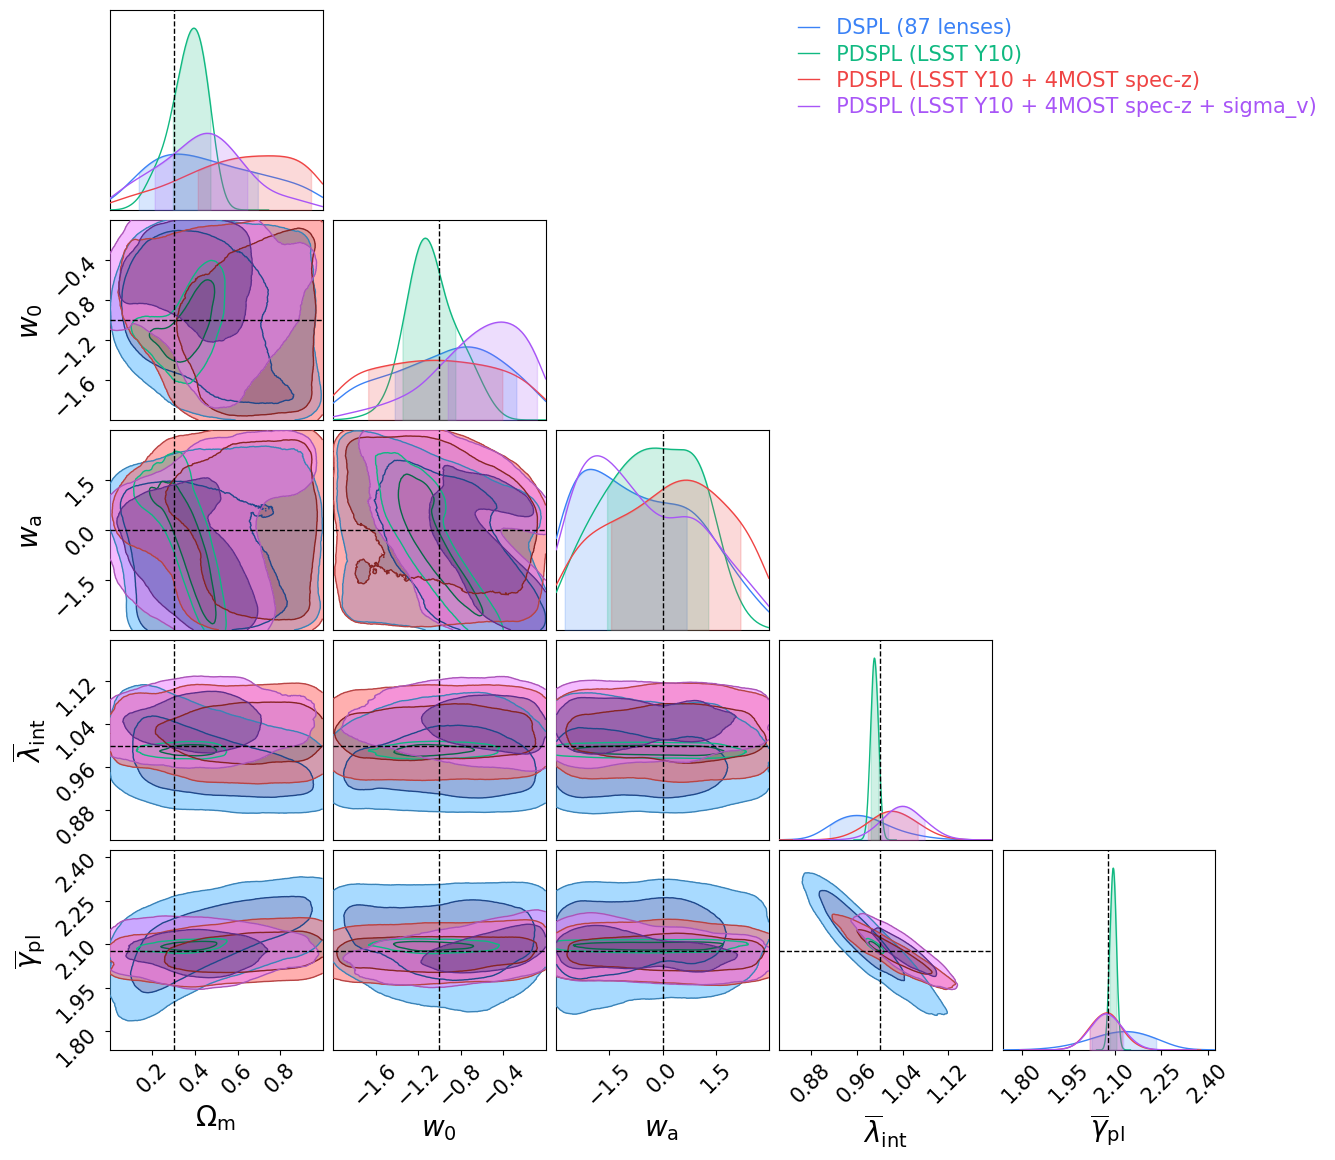

In [ ]:
consumer = ChainConsumer()

for key in keys_to_run_forecast:
    chain = forecast_samples[key]['ChainConsumer-Chain']
    consumer.add_chain(chain)

# add truth values
consumer.add_truth(
    Truth(
    location = {
        r"$\Omega_{\rm m}$": om_true,
        r"$w_0$": w0_true,
        r"$w_{\rm a}$": wa_true,
        r"$\overline{\lambda}_{\rm int}$": lambda_mst_mean,
        r"$\overline{\gamma}_{\rm pl}$": gamma_pl_mean,
        # r"$\sigma(\gamma_{\rm pl, global})$": gamma_pl_sigma,
    }
)
)

##### configure plot settings

# extents = {
#                 r"$w_0$": [-2, 0],
#                 r"$w_{\rm a}$": [-3, 3],
#                 r"$\Omega_{\rm m}$": [0.1, 0.5],
#                 r"$\overline{\lambda}_{\rm int}$": [0.8, 1.2],
#                 r"$\overline{\gamma}_{\rm pl}$": [1.5, 2.5],
#                 # r"$\sigma(\gamma_{\rm pl, global})$": [0.0, 0.32],
#             }

consumer.set_plot_config(
        PlotConfig(
            sigmas=[1, 2],
            # extents=extents,
            plot_hists=True,
            legend_kwargs={
                "loc": "upper left",
                "bbox_to_anchor": (-1, 1.),
                "fontsize": 15,
            },
            legend_artists=False,
            tick_font_size=15,
            label_font_size=20,
        )
    )

consumer.set_plot_config(
        PlotConfig(
            sigmas=[1, 2],
            # extents=extents,
            plot_hists=True,
            legend_kwargs={
                "loc": "upper left",
                "bbox_to_anchor": (-1, 1.),
                "fontsize": 15,
            },
            legend_artists=False,
            tick_font_size=15,
            label_font_size=20,
        )
    )

#### Plot and save the forecast results
fig = consumer.plotter.plot(
    columns=[
            '$\\Omega_{\\rm m}$',
            '$w_0$',
            '$w_{\\rm a}$',
            '$\\overline{\\lambda}_{\\rm int}$',
            '$\\overline{\\gamma}_{\\rm pl}$',
            # '$\\sigma(\\gamma_{\\rm pl, global})$'
            ],
    # figsize=(figure_width_inches * 0.8, figure_width_inches * 0.8),
)

# consumer.configure(
# )
# consumer.set_override(
# )

# save figure
fig.savefig(f"../figures/forecast_w0waCDM.png", dpi=300, bbox_inches='tight')

Parameter $w_{\rm a}$ in chain PDSPL (LSST Y10 + 4MOST spec-z + sigma_v) is not constrained


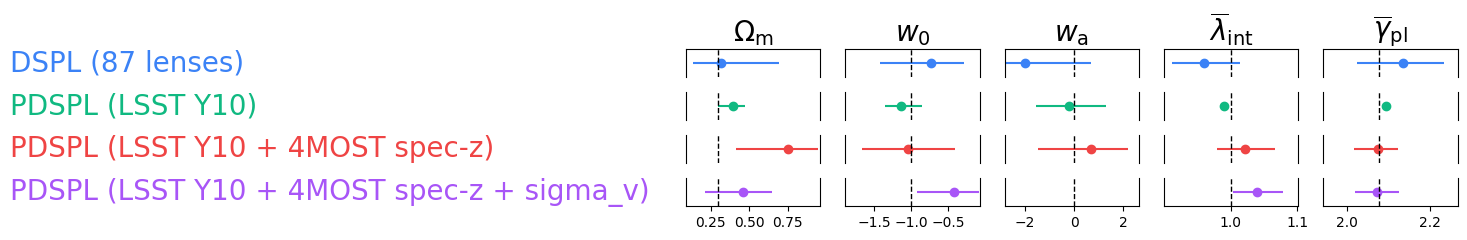

In [123]:
fig = consumer.plotter.plot_summary(errorbar=True);
fig.tight_layout()

In [124]:
latex_table = consumer.analysis.get_latex_table()
print(latex_table)

Parameter $w_{\rm a}$ in chain PDSPL (LSST Y10 + 4MOST spec-z + sigma_v) is not constrained


\begin{table}
    \centering
    \caption{}
    \label{tab:model_params}
    \begin{tabular}{cccccc}
        \hline
		Model & $\Omega_{\rm m}$ & $w_0$ & $w_{\rm a}$ & $\overline{\lambda}_{\rm int}$ & $\overline{\gamma}_{\rm pl}$ \\ 
		\hline
		DSPL (87 lenses) & $0.32^{+0.38}_{-0.18}$ & $-0.74^{+0.46}_{-0.68}$ & $-2.02^{+2.70}_{-0.74}$ & $0.961^{+0.054}_{-0.048}$ & $2.135^{+0.098}_{-0.111}$ \\ 
		PDSPL (LSST Y10) & $0.395^{+0.078}_{-0.098}$ & $-1.13^{+0.28}_{-0.22}$ & $-0.2^{+1.5}_{-1.3}$ & $\left( 990.7^{+7.3}_{-6.6} \right) \times 10^{-3}$ & $2.095^{+0.010}_{-0.011}$ \\ 
		PDSPL (LSST Y10 + 4MOST spec-z) & $0.75^{+0.19}_{-0.34}$ & $-1.04^{+0.64}_{-0.63}$ & $0.7^{+1.5}_{-2.1}$ & $1.021^{+0.045}_{-0.042}$ & $2.074^{+0.048}_{-0.057}$ \\ 
		PDSPL (LSST Y10 + 4MOST spec-z + sigma_v) & $0.46^{+0.19}_{-0.25}$ & $-0.42^{+0.33}_{-0.51}$ &  & $1.040^{+0.039}_{-0.036}$ & $2.073^{+0.054}_{-0.055}$ \\ 
		\hline
    \end{tabular}
\end{table}


Parameter $w_{\rm a}$ in chain PDSPL (LSST Y10 + 4MOST spec-z + sigma_v) is not constrained


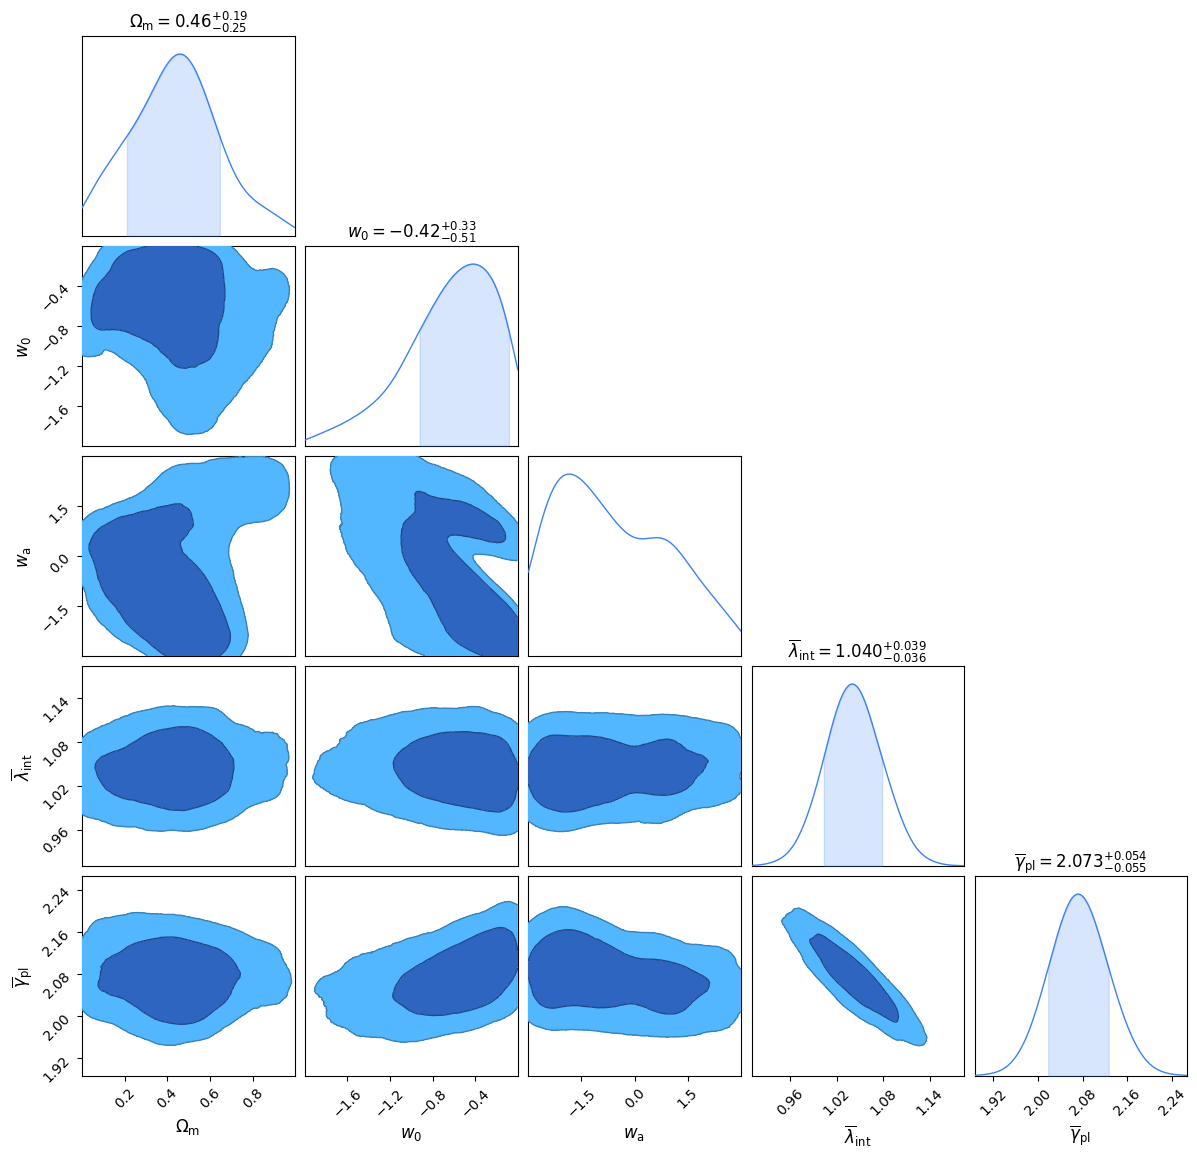

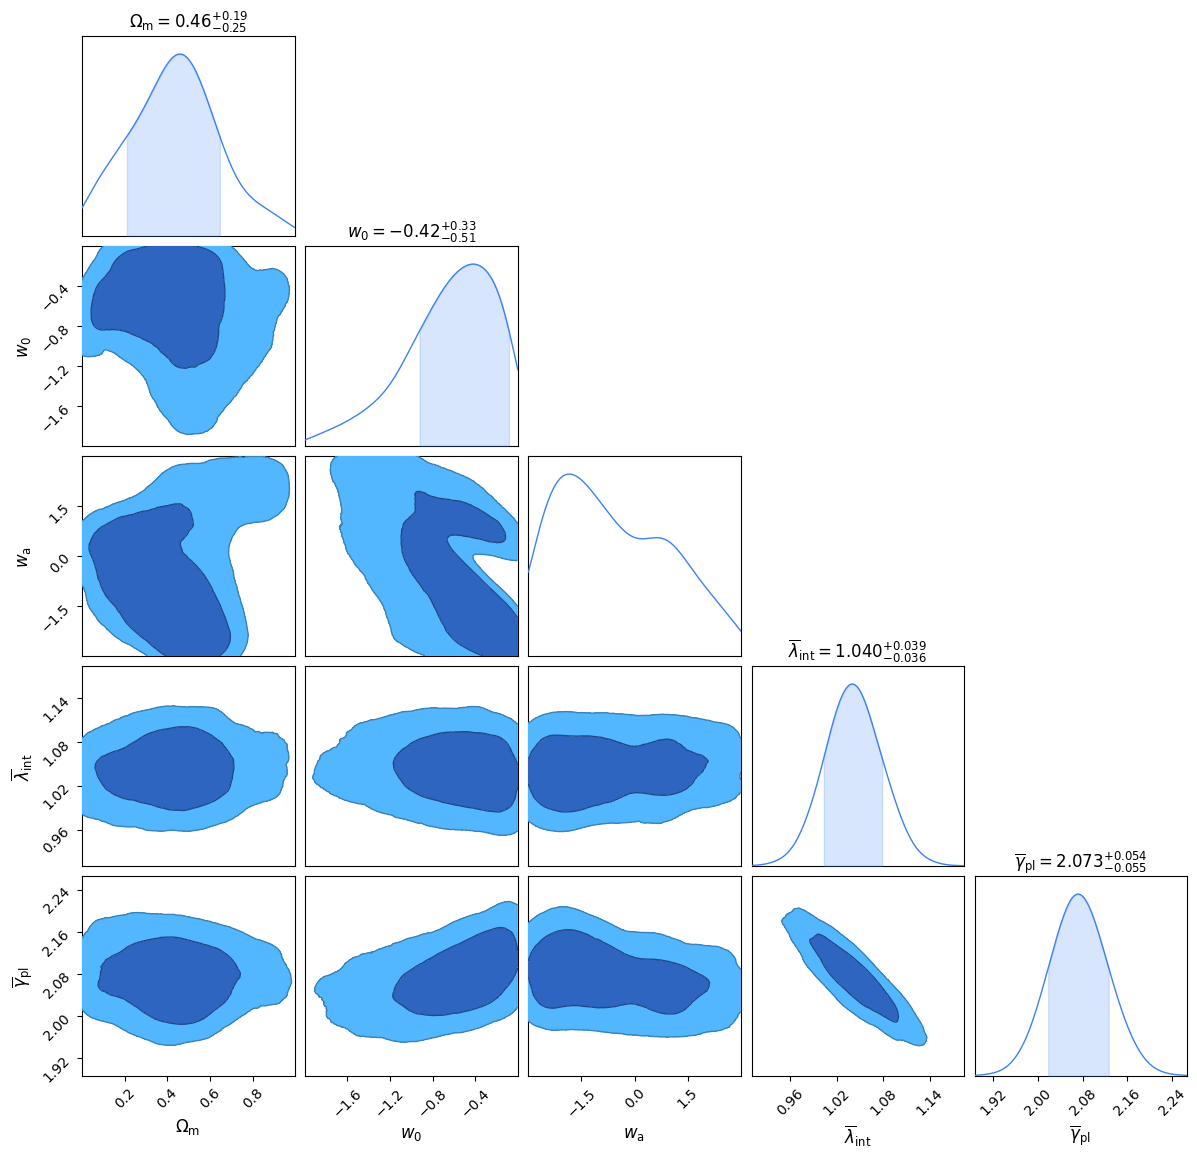

In [125]:
consumer = ChainConsumer()
consumer.add_chain(forecast_samples['lsst_4most_spec-z_sigma_v']['ChainConsumer-Chain'])
consumer.plotter.plot()

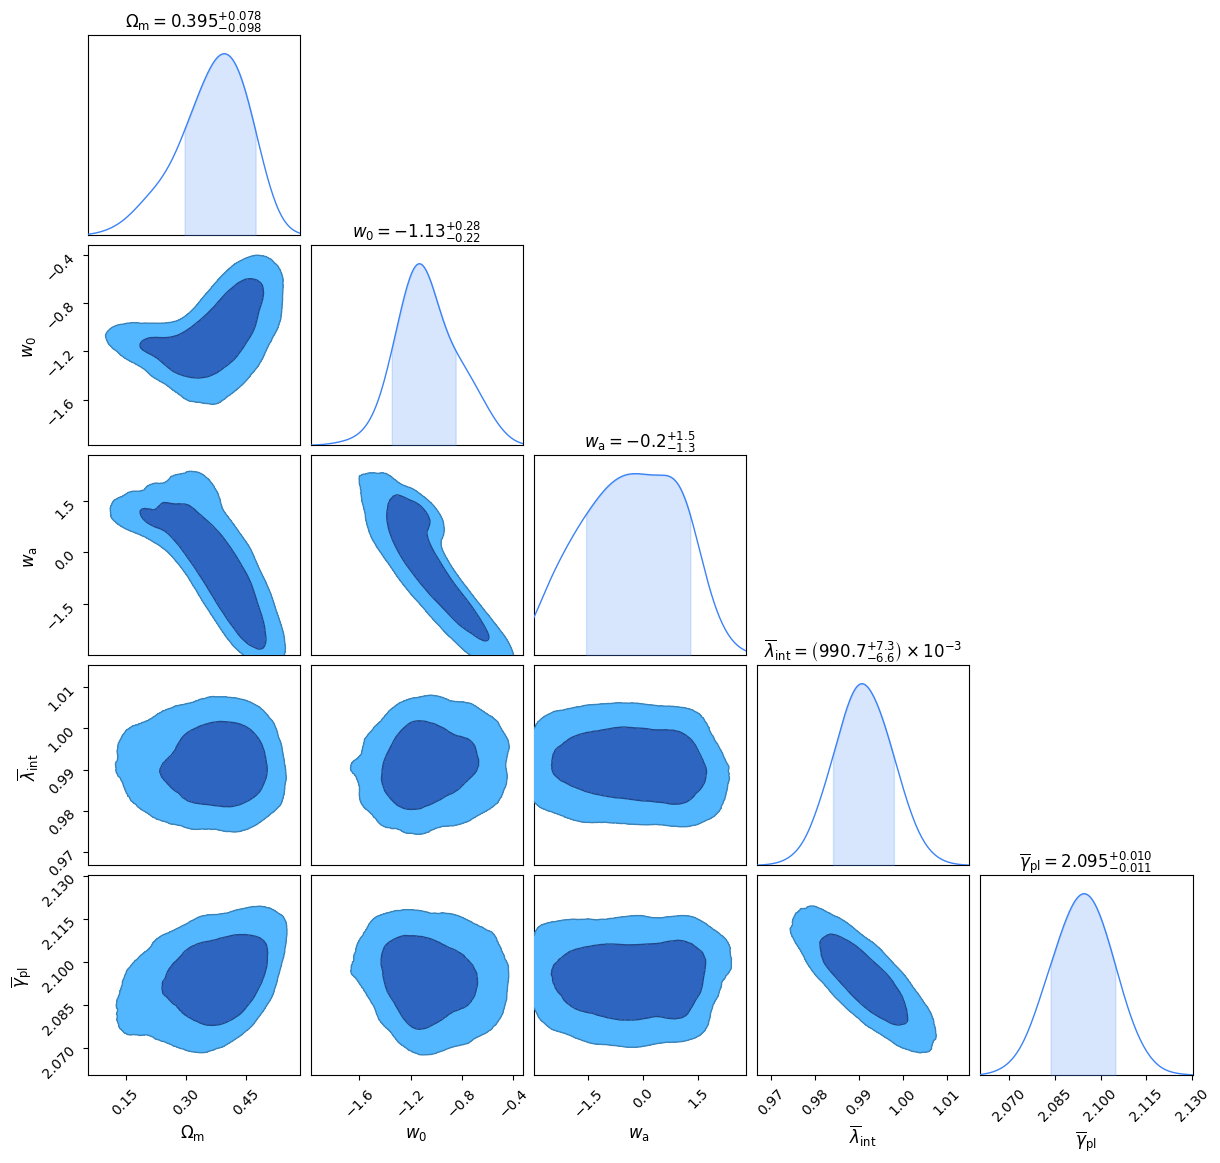

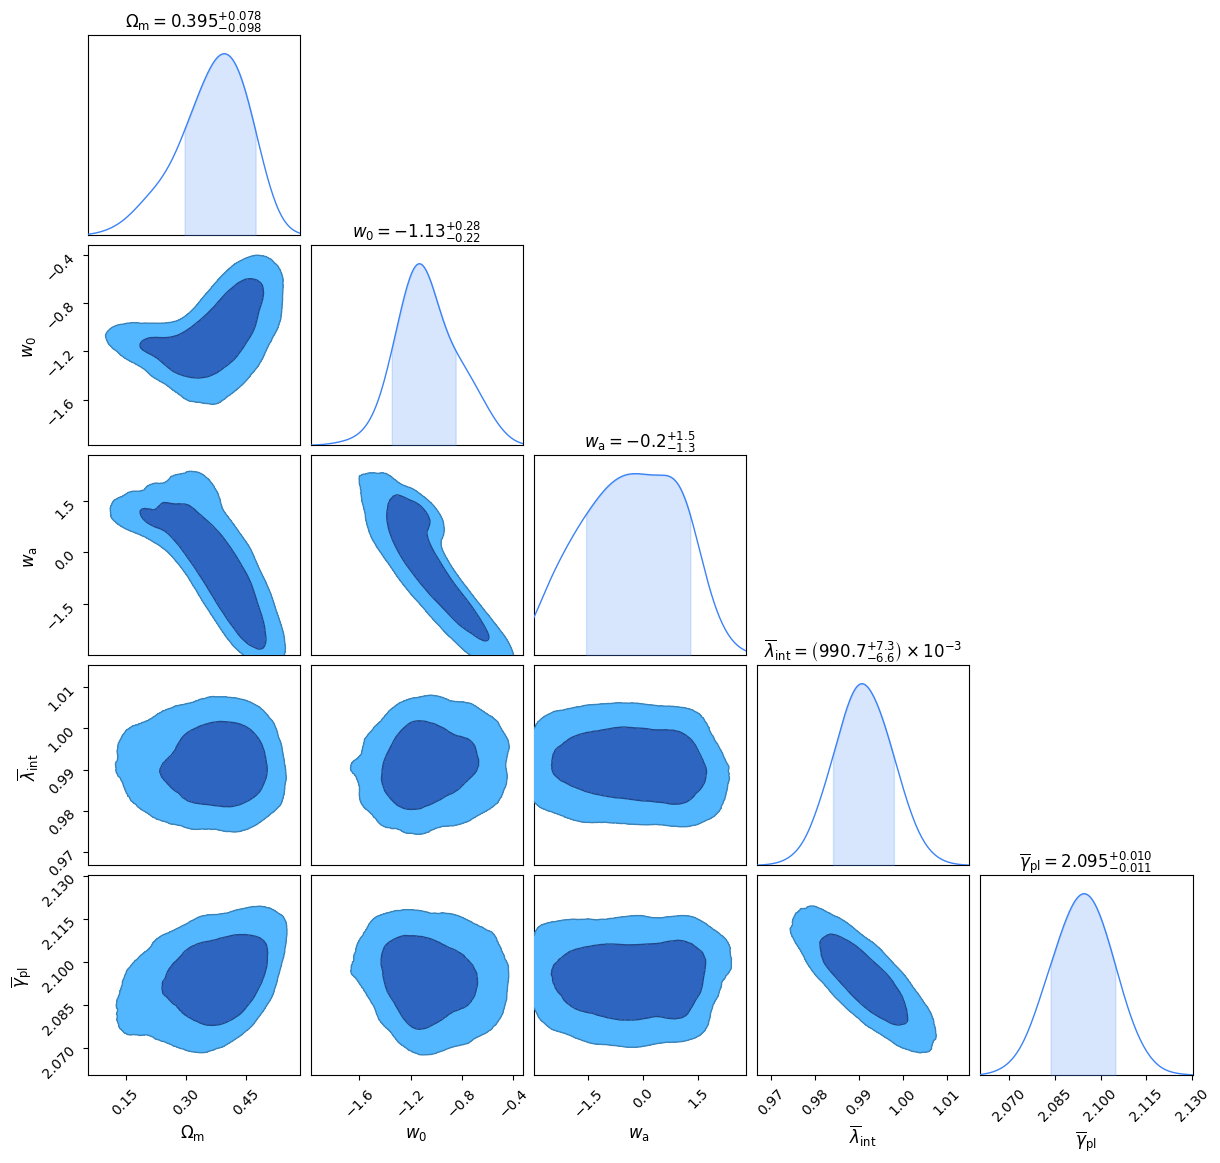

In [126]:
consumer = ChainConsumer()
consumer.add_chain(forecast_samples['lsst_y10']['ChainConsumer-Chain'])
consumer.plotter.plot()

## Make combined plot - Prior on $\Omega_{\rm m}$, $\lambda_{\rm MST}$, and $\gamma_{\rm pl}$

In [127]:
# external priors

sigma_lambda_prior = 0.01
sigma_gamma_prior = 0.01
sigma_omega_m_prior = 0.05
sigma_wa_prior = 0.4


#flat_samples = sampler.get_chain(discard=n_burn, thin=1, flat=True)

#print(joint_chain.samples[r"$\overline{\lambda}_{\rm int}$"])

def add_prior_to_chain(chain):
    chain_weights = copy.deepcopy(chain)
    lambda_int = chain.samples[r"$\overline{\lambda}_{\rm int}$"]
    om = chain.samples[r"$\Omega_{\rm m}$"]
    gamma_pl = chain.samples[r"$\overline{\gamma}_{\rm pl}$"]
    wa = chain.samples[r"$w_{\rm a}$"]
    weights_om = -(om - om_true)**2 / (2*sigma_omega_m_prior**2)
    weights_lambda = -(lambda_int - lambda_mst_mean)**2 / (2*sigma_lambda_prior**2)
    weights_gamma = -(gamma_pl - gamma_pl_mean)**2 / (2*sigma_gamma_prior**2)
    weights_wa = -(wa - wa_true)**2 / (2*sigma_wa_prior**2)
    weights = np.exp(weights_gamma + weights_lambda + weights_om + weights_wa)
    weights[weights < 10**(-10)] = 10**(-10)
    chain_weights.samples["weight"] = weights
    chain_weights.name = chain.name+" + deflector prior"
    return chain_weights

In [128]:
for key in keys_to_run_forecast:
    chain = forecast_samples[key]['ChainConsumer-Chain']
    chain_with_prior = add_prior_to_chain(chain)
    forecast_samples[key]['ChainConsumer-Chain-with-prior'] = chain_with_prior

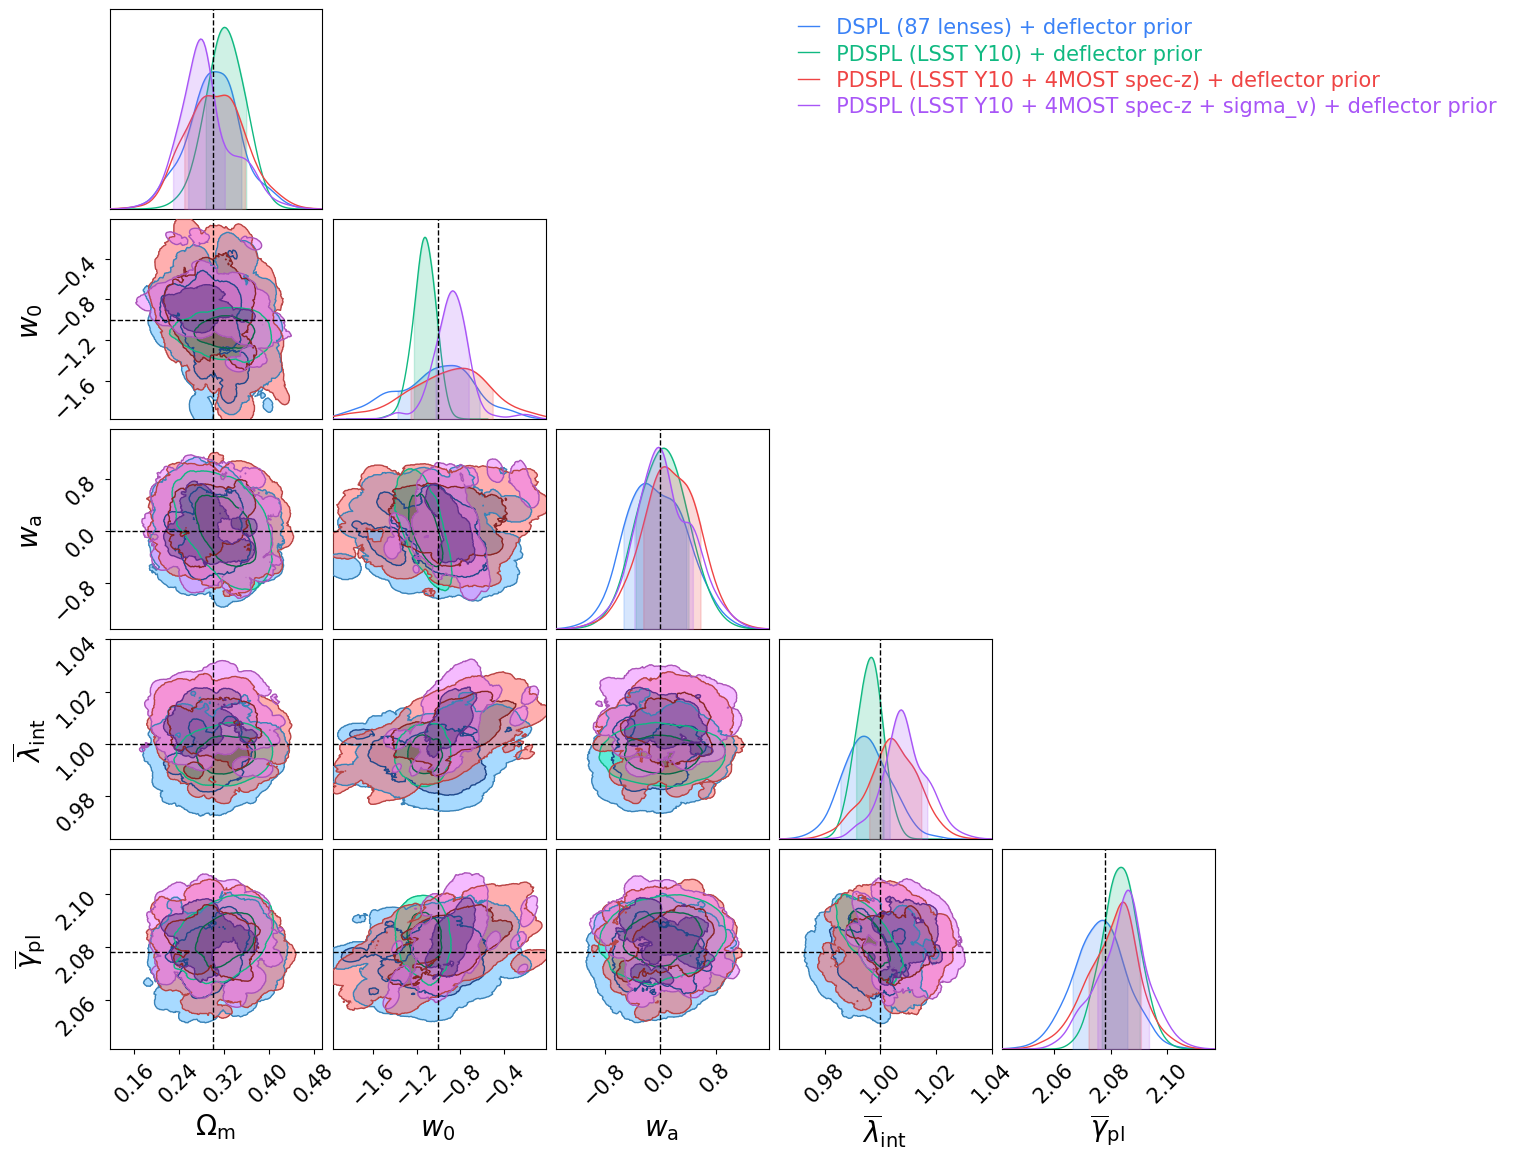

In [129]:
consumer = ChainConsumer()

for key in keys_to_run_forecast:
    chain_prior = forecast_samples[key]['ChainConsumer-Chain-with-prior']
    consumer.add_chain(chain_prior)

# add truth values
consumer.add_truth(
    Truth(
    location = {
        r"$\Omega_{\rm m}$": om_true,
        r"$w_0$": w0_true,
        r"$w_{\rm a}$": wa_true,
        r"$\overline{\lambda}_{\rm int}$": lambda_mst_mean,
        r"$\overline{\gamma}_{\rm pl}$": gamma_pl_mean,
        # r"$\sigma(\gamma_{\rm pl, global})$": gamma_pl_sigma,
    }
)
)

##### configure plot settings

# extents = {
#                 r"$w_0$": [-2, 0],
#                 r"$w_{\rm a}$": [-3, 3],
#                 r"$\Omega_{\rm m}$": [0.1, 0.5],
#                 r"$\overline{\lambda}_{\rm int}$": [0.8, 1.2],
#                 r"$\overline{\gamma}_{\rm pl}$": [1.5, 2.5],
#                 # r"$\sigma(\gamma_{\rm pl, global})$": [0.0, 0.32],
#             }

consumer.set_plot_config(
        PlotConfig(
            sigmas=[1, 2],
            # extents=extents,
            plot_hists=True,
            legend_kwargs={
                "loc": "upper left",
                "bbox_to_anchor": (-1, 1.),
                "fontsize": 15,
            },
            legend_artists=False,
            tick_font_size=15,
            label_font_size=20,
        )
    )

#### Plot and save the forecast results
fig = consumer.plotter.plot(
    columns=[
            '$\\Omega_{\\rm m}$',
            '$w_0$',
            '$w_{\\rm a}$',
            '$\\overline{\\lambda}_{\\rm int}$',
            '$\\overline{\\gamma}_{\\rm pl}$',
            # '$\\sigma(\\gamma_{\\rm pl, global})$'
            ],
    # figsize=(figure_width_inches * 0.8, figure_width_inches * 0.8),
)


# save figure
fig.savefig(f"../figures/forecast_w0waCDM_with_prior.png", dpi=300, bbox_inches='tight')

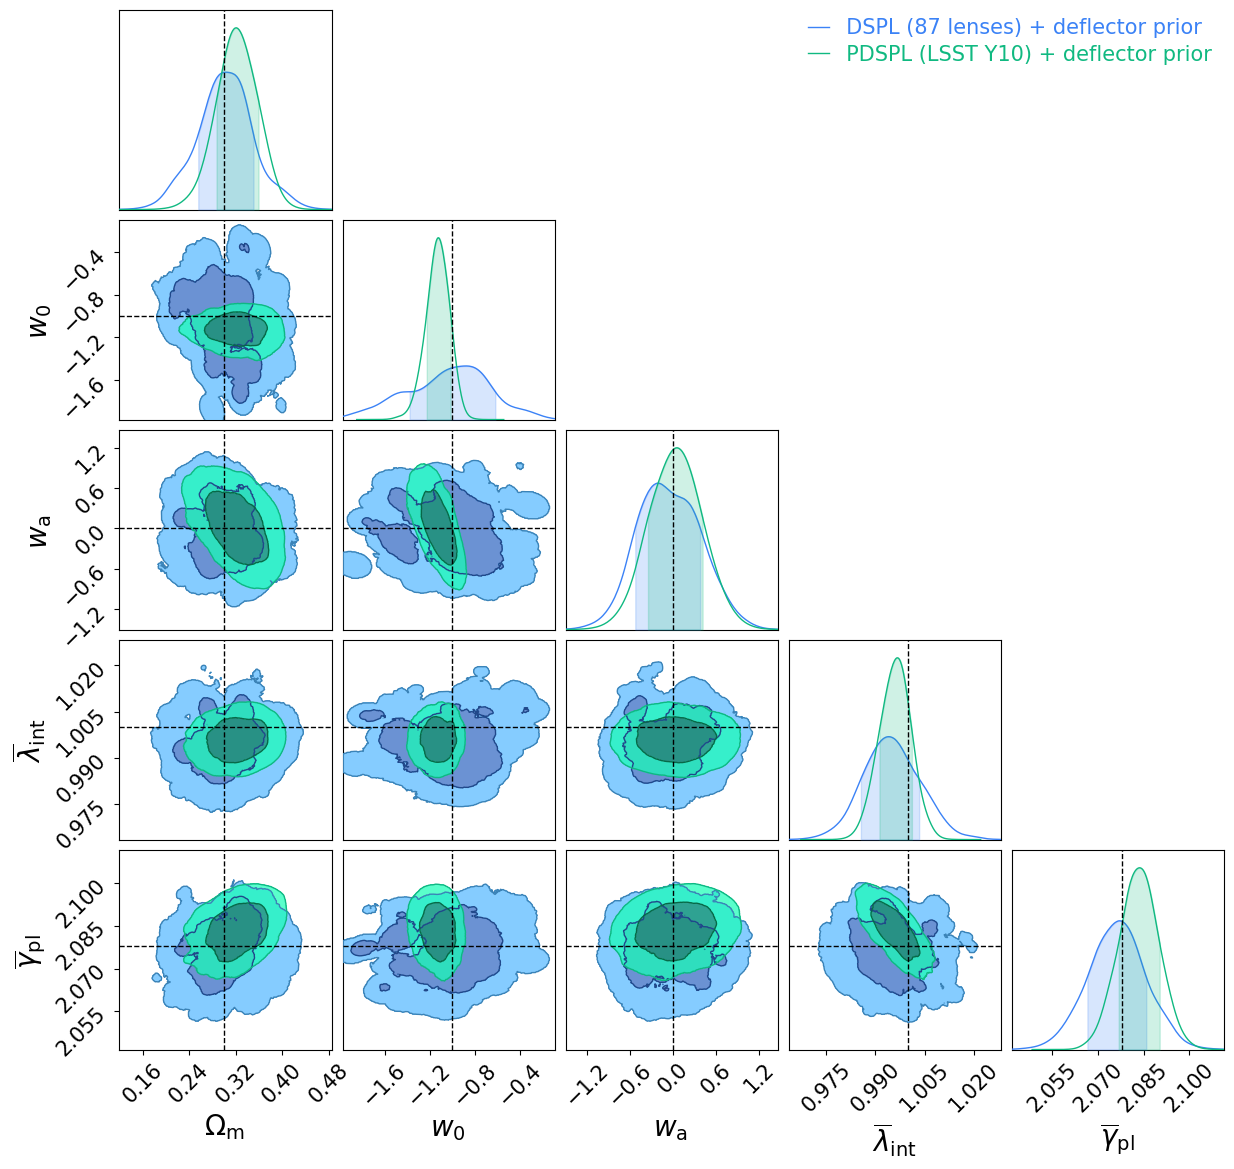

In [130]:
consumer = ChainConsumer()

# for key in keys_to_run_forecast:
#     chain_prior = forecast_samples[key]['ChainConsumer-Chain-with-prior']
#     consumer.add_chain(chain_prior)
consumer.add_chain(forecast_samples['DSPL']['ChainConsumer-Chain-with-prior'])
consumer.add_chain(forecast_samples['lsst_y10']['ChainConsumer-Chain-with-prior'])

# add truth values
consumer.add_truth(
    Truth(
    location = {
        r"$\Omega_{\rm m}$": om_true,
        r"$w_0$": w0_true,
        r"$w_{\rm a}$": wa_true,
        r"$\overline{\lambda}_{\rm int}$": lambda_mst_mean,
        r"$\overline{\gamma}_{\rm pl}$": gamma_pl_mean,
        # r"$\sigma(\gamma_{\rm pl, global})$": gamma_pl_sigma,
    }
)
)

##### configure plot settings

# extents = {
#                 r"$w_0$": [-2, 0],
#                 r"$w_{\rm a}$": [-3, 3],
#                 r"$\Omega_{\rm m}$": [0.1, 0.5],
#                 r"$\overline{\lambda}_{\rm int}$": [0.8, 1.2],
#                 r"$\overline{\gamma}_{\rm pl}$": [1.5, 2.5],
#                 # r"$\sigma(\gamma_{\rm pl, global})$": [0.0, 0.32],
#             }

consumer.set_plot_config(
        PlotConfig(
            sigmas=[1, 2],
            # extents=extents,
            plot_hists=True,
            legend_kwargs={
                "loc": "upper left",
                "bbox_to_anchor": (-1, 1.),
                "fontsize": 15,
            },
            legend_artists=False,
            tick_font_size=15,
            label_font_size=20,
        )
    )

#### Plot and save the forecast results
fig = consumer.plotter.plot(
    columns=[
            '$\\Omega_{\\rm m}$',
            '$w_0$',
            '$w_{\\rm a}$',
            '$\\overline{\\lambda}_{\\rm int}$',
            '$\\overline{\\gamma}_{\\rm pl}$',
            # '$\\sigma(\\gamma_{\\rm pl, global})$'
            ],
    # figsize=(figure_width_inches * 0.8, figure_width_inches * 0.8),
)


# save figure
# fig.savefig(f"../figures/forecast_w0waCDM_with_prior.png", dpi=300, bbox_inches='tight')

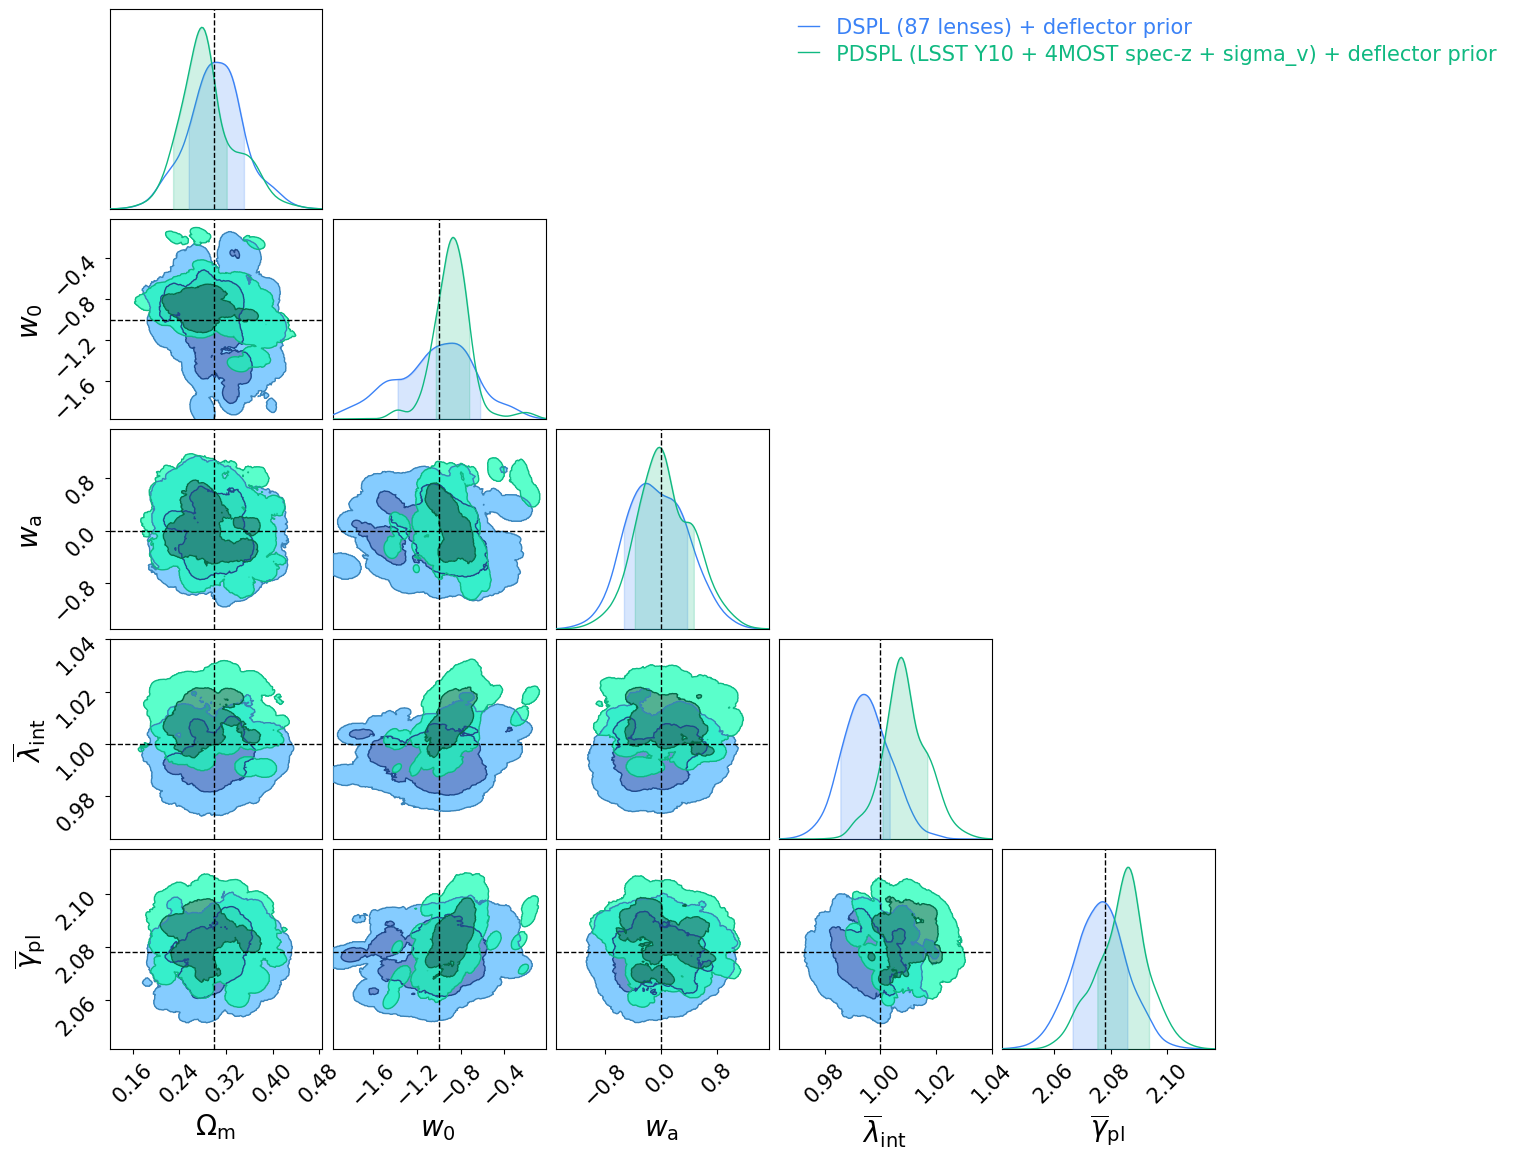

In [131]:
consumer = ChainConsumer()

# for key in keys_to_run_forecast:
#     chain_prior = forecast_samples[key]['ChainConsumer-Chain-with-prior']
#     consumer.add_chain(chain_prior)
consumer.add_chain(forecast_samples['DSPL']['ChainConsumer-Chain-with-prior'])
consumer.add_chain(forecast_samples['lsst_4most_spec-z_sigma_v']['ChainConsumer-Chain-with-prior'])

# add truth values
consumer.add_truth(
    Truth(
    location = {
        r"$\Omega_{\rm m}$": om_true,
        r"$w_0$": w0_true,
        r"$w_{\rm a}$": wa_true,
        r"$\overline{\lambda}_{\rm int}$": lambda_mst_mean,
        r"$\overline{\gamma}_{\rm pl}$": gamma_pl_mean,
        # r"$\sigma(\gamma_{\rm pl, global})$": gamma_pl_sigma,
    }
)
)

##### configure plot settings

# extents = {
#                 r"$w_0$": [-2, 0],
#                 r"$w_{\rm a}$": [-3, 3],
#                 r"$\Omega_{\rm m}$": [0.1, 0.5],
#                 r"$\overline{\lambda}_{\rm int}$": [0.8, 1.2],
#                 r"$\overline{\gamma}_{\rm pl}$": [1.5, 2.5],
#                 # r"$\sigma(\gamma_{\rm pl, global})$": [0.0, 0.32],
#             }

consumer.set_plot_config(
        PlotConfig(
            sigmas=[1, 2],
            # extents=extents,
            plot_hists=True,
            legend_kwargs={
                "loc": "upper left",
                "bbox_to_anchor": (-1, 1.),
                "fontsize": 15,
            },
            legend_artists=False,
            tick_font_size=15,
            label_font_size=20,
        )
    )

#### Plot and save the forecast results
fig = consumer.plotter.plot(
    columns=[
            '$\\Omega_{\\rm m}$',
            '$w_0$',
            '$w_{\\rm a}$',
            '$\\overline{\\lambda}_{\\rm int}$',
            '$\\overline{\\gamma}_{\\rm pl}$',
            # '$\\sigma(\\gamma_{\\rm pl, global})$'
            ],
    # figsize=(figure_width_inches * 0.8, figure_width_inches * 0.8),
)


# save figure
# fig.savefig(f"../figures/forecast_w0waCDM_with_prior.png", dpi=300, bbox_inches='tight')